# Basics with images

* Find this notebook at `EpyNN/nnlive/dummy_image/train.ipynb`.
* Regular python code at `EpyNN/nnlive/dummy_image/train.py`.

In this notebook we will review:

* Handling numerical data image to proceed with Neural Network regression.
* Training of Feed-Forward (FF) and Convolutional Neural Network (CNN) for binary classification task.
* Overfitting of the model to the training data and impact of Dropout regularization

Please see the following if you get lost:

* [Fully Connected (Dense)](../../Dense.html)
* [Convolution (CNN)](../../Convolution.html)
* [Pooling (CNN)](../../Pooling.html)

## Environment and data

Follow [this link](prepare_dataset.ipynb) for details about data preparation.

Briefly, grayscale images were generated by random selection of tones. Each image represents one sample features. Such random features may have been alterated or not by setting a fraction of the pixel to the highest level of tone in the palette.

The goal of the neural network training is to build a classifier able to detect if a presumably random image has been altered or not. Said differently, we are going to try detecting deviation or anomaly with respect to the expected distribution of randomly choosen tones within the image.

In [1]:
# EpyNN/nnlive/dummy_image/train.ipynb
# Standard library imports
import random

# Related third party imports
import matplotlib.pyplot as plt
import numpy as np

# Local application/library specific imports
import nnlibs.initialize
from nnlibs.commons.maths import relu, softmax
from nnlibs.commons.library import (
    configure_directory,
    read_model,
)
from nnlibs.network.models import EpyNN
from nnlibs.embedding.models import Embedding
from nnlibs.convolution.models import Convolution
from nnlibs.pooling.models import Pooling
from nnlibs.flatten.models import Flatten
from nnlibs.dropout.models import Dropout
from nnlibs.dense.models import Dense
from prepare_dataset import prepare_dataset
from settings import se_hPars


########################## CONFIGURE ##########################
random.seed(0)
np.random.seed(1)

np.set_printoptions(threshold=10)

np.seterr(all='warn')

configure_directory()


############################ DATASET ##########################
X_features, Y_label = prepare_dataset(N_SAMPLES=750)

Let's control what we retrieved.

In [2]:
print(len(X_features))
print(X_features[0].shape)

750
(28, 28, 1)


We retrieved sample features describing ``7500`` samples.

For each sample, we retrieved  features as a three-dimensional array of shape ``(widht, height, depth)``.

In the context, remember that the ``depth`` dimension represents the number of channels which encode the image. While the depth of any RGB image would be equal to 3, the depth of a grayscale image is equal to one.

Let's recall how this looks like.

label: 1


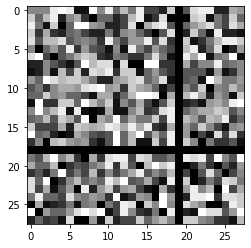

label: 0


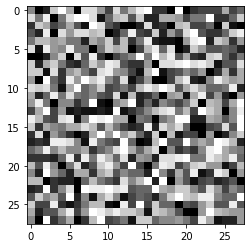

In [3]:
print('label:', Y_label[0])
plt.imshow(X_features[0], cmap='gray')
plt.show()

print('label:', Y_label[4])
plt.imshow(X_features[4], cmap='gray')
plt.show()

The first image is associated with a ``label: 0`` (random image) while the second is associated with ``label: 1`` (non-random image).

It is not that obvious than the second image deviates from a random distribution of tones, but one may still oserve that white pixels seems to be over-represented in the second image compared to the first one.

Let see if we can, just on those two images, show it.

In [4]:
print(np.count_nonzero(X_features[0] == np.max(X_features[0])))    # Random image
print(np.count_nonzero(X_features[4] == np.max(X_features[4])))    # Manipulated image

42
55


Indeed there are 12 more white pixels in the image with ``label: 1`` compared to the image with ``label: 0``. Since we expectedly altered 10% of the image pixels with the highest tone - which renders to white in matplotlib - then we can somehow be confident and go ahead.

Note that double-checking the data is important: nobody wants to waste a day of work at trying to fit unconsistent data.

## Feed-Forward (FF)

We will first engage in designing a Feed-Forward network.

### Embedding

We first instantiate the embedding layer which is on top of the network.

In [5]:
embedding = Embedding(X_data=X_features,
                      Y_data=Y_label,
                      X_scale=True,
                      Y_encode=True,
                      batch_size=32,
                      relative_size=(2, 1, 0))

Note that we set ``X_scale=True`` in order to normalize the whole input array of sample features within \[0, 1\]. Although the neural network may theoretically achieves this normalization by itself, it may rather be slowing down training and convergence pretty much. In general, it is thus recommended to apply normalization within \[0, 1\] or, alternatively, \[-1, 1\].

We have also set a ``batch_size=32`` which represents the number of samples from which gradients are computed and parameters updated. There are ``N_SAMPLES/batch_size`` parameters update per training epoch.

### Flatten-(Dense)n with Dropout

_

In [6]:
name = 'Flatten_Dropout-02_Dense-64-relu_Dropout-05_Dense-2-softmax'

se_hPars['learning_rate'] = 0.01

flatten = Flatten()

dropout1 = Dropout(drop_prob=0.2)

hidden_dense = Dense(64, relu)

dropout2 = Dropout(drop_prob=0.5)

dense = Dense(2, softmax)

layers = [embedding, flatten, dropout1, hidden_dense, dropout2, dense]

model = EpyNN(layers=layers, name=name)

We have set up a first *dropout1* between the *flatten* and *hidden_dense* layer as well as a second one between *hidden_dense* and *dense*.

In [7]:
model.initialize(loss='MSE', seed=1, se_hPars=se_hPars.copy(), end='\r')

_

In [8]:
model.train(epochs=100, init_logs=False)

Epoch 99 - Batch 14/14 - Accuracy: 0.969 Cost: 0.0357 - TIME: 75.81s RATE: 7.44e+04e/s TTC: 0sm

+-------+----------+----------+-------+----------+-------+-------+------------------------------------------------------------------------+
| epoch |  lrate   |  lrate   |       | accuracy |       |  MSE  |                               Experiment                               |
|       |  Dense   |  Dense   |  (0)  |   (1)    |  (0)  |  (1)  |                                                                        |
+-------+----------+----------+-------+----------+-------+-------+------------------------------------------------------------------------+
|   0   | 1.00e-02 | 1.00e-02 | 0.532 |  0.484   | 0.253 | 0.260 | 1630339679_Flatten_Dropout-02_Dense-64-relu_Dropout-05_Dense-2-softmax |
|  10   | 1.00e-02 | 1.00e-02 | 0.658 |  0.480   | 0.220 | 0.272 | 1630339679_Flatten_Dropout-02_Dense-64-relu_Dropout-05_Dense-2-softmax |
|  20   | 1.00e-02 | 1.00e-02 | 0.692 |  0.520   | 0.202 | 0.27

_

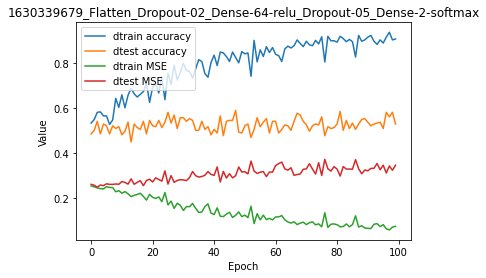

In [9]:
model.plot(path=False)

_

## Convolutional Neural Network (CNN)

_

### Embedding

_

In [10]:
embedding = Embedding(X_data=X_features,
                      Y_data=Y_label,
                      X_scale=True,
                      Y_encode=True,
                      batch_size=32,
                      relative_size=(2, 1, 0))

_

### Conv-Pool-Flatten-Dense

_

In [11]:
name = 'Convolution-6-2_Pooling-3-3-Max_Flatten_Dense-2-softmax'

se_hPars['learning_rate'] = 0.001

convolution = Convolution(unit_filters=6, filter_size=(4, 4), activate=relu)

pooling = Pooling(pool_size=(2, 2))

flatten = Flatten()

dense = Dense(2, softmax)

layers = [embedding, convolution, pooling, flatten, dense]

model = EpyNN(layers=layers, name=name)

_

In [12]:
model.initialize(loss='MSE', seed=1, se_hPars=se_hPars.copy(), end='\r')

_

In [13]:
model.train(epochs=100, init_logs=False)

Epoch 99 - Batch 14/14 - Accuracy: 0.719 Cost: 0.19122 - TIME: 85.25s RATE: 1.83e+04e/s TTC: 0s

+-------+-------------+----------+-------+----------+-------+-------+--------------------------------------------------------------------+
| epoch |    lrate    |  lrate   |       | accuracy |       |  MSE  |                             Experiment                             |
|       | Convolution |  Dense   |  (0)  |   (1)    |  (0)  |  (1)  |                                                                    |
+-------+-------------+----------+-------+----------+-------+-------+--------------------------------------------------------------------+
|   0   |  1.00e-03   | 1.00e-03 | 0.498 |  0.496   | 0.276 | 0.286 | 1630339755_Convolution-6-2_Pooling-3-3-Max_Flatten_Dense-2-softmax |
|  10   |  1.00e-03   | 1.00e-03 | 0.592 |  0.528   | 0.235 | 0.247 | 1630339755_Convolution-6-2_Pooling-3-3-Max_Flatten_Dense-2-softmax |
|  20   |  1.00e-03   | 1.00e-03 | 0.640 |  0.580   | 0.228 | 0.239 |

_

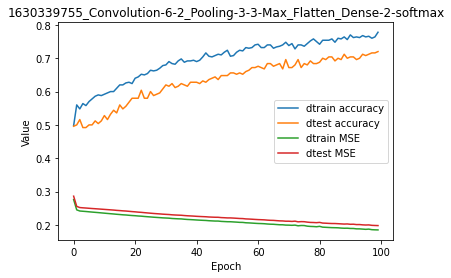

In [14]:
model.plot(path=False)

_

## Write, Read & Predict

In [15]:
### Write/read model

model.write()

model = read_model()


### Predict

X_features, _ = prepare_dataset(N_SAMPLES=10)

dset = model.predict(X_features, X_scale=True)

for n, pred, probs in zip(dset.ids, dset.P, dset.A):
    print(n, pred, probs)

Make: /media/synthase/beta/EpyNN/nnlive/dummy_image/models/1630339755_Convolution-6-2_Pooling-3-3-Max_Flatten_Dense-2-softmax.pickle
0 1 [0.16239731 0.83760269]
1 0 [0.72239584 0.27760416]
2 1 [0.30109132 0.69890868]
3 0 [0.6965525 0.3034475]
4 1 [0.38170545 0.61829455]
5 0 [0.52157935 0.47842065]
6 0 [0.65515745 0.34484255]
7 0 [0.5106849 0.4893151]
8 0 [0.59498688 0.40501312]
9 1 [0.28224866 0.71775134]
